In [1]:
import os
import sys
import tensorflow as tf
import _pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as backend
%matplotlib inline

In [2]:
dataset = pkl.load(open(r'C:\Users\Lenovo\Desktop\AI_project\dataset.pkl', 'rb'))

## Read Data

In [3]:
X = [dataset['contaminated'][p] for p in dataset['contaminated']]
y = [dataset['pure'][p] for p in dataset['pure']]
del dataset

In [4]:
np.random.seed(0)
train_patients = np.random.choice(len(X), 38, replace=False)
test_patients = np.array(list(set(np.arange(len(X))) - set(train_patients)))
heldout_patients = test_patients[-8:]
test_patients = test_patients[:8]
X_train, y_train = [X[i].T for i in train_patients], [y[i].T for i in train_patients]
X_test, y_test = [X[i].T for i in test_patients], [y[i].T for i in test_patients]
X_heldout, y_heldout = [X[i].T for i in heldout_patients], [y[i].T for i in heldout_patients]
del X
del y

## Params

In [5]:
problem = 'denoise'
learning_rate = 1e-3
batch_size = 32
window_size = 128
num_epochs = 100
epoch_size = max(len(np.concatenate(X_train)) // batch_size // window_size, 20)
if problem == 'classification':
    num_classes = len(set(y_train[0].reshape(-1)))
elif problem == 'regression':
    num_classes = 1
elif problem == 'denoise':
    num_classes = None
else:
    raise ValueError('Problem type invalid!')

## Batch generator

In [6]:
## First preprocess func: data normalizer
std = np.std(np.concatenate(X_train, 0), 0, keepdims=True)
mean = np.mean(np.concatenate(X_train, 0), 0, keepdims=True)
# mn = np.min(np.concatenate(X_train, 0), 0, keepdims=True)
# mx = np.max(np.concatenate(X_train, 0), 0, keepdims=True)
mn = np.min(np.concatenate(X_train, 0))
mx = np.max(np.concatenate(X_train, 0))
def standardize(x, y_min=0, y_max=1):
    return (x - mn) / (mx - mn) * (y_max - y_min) + y_min

def destandardize(x, y_min=0, y_max=1):
    return (x - y_min) / (y_max - y_min) * (mx - mn) + mn
    
def normalize(x):
    return (x - mean) / np.clip(std, 1e-12, None)

def denormalize(x):
    return (x * std) + mean

def standardizer_fn(x, y):
    return standardize(x), standardize(y)

def destandardizer_fn(x, y):
    return destandardize(x), destandardize(y)

def normalizer_fn(x, y):
    return normalize(x), normalize(y)

def denormalizer_fn(x, y):
    return denormalize(x), denormalize(y)

def augmentor_fn(x, y):
    noise = x - y
    x_augmented = y + np.random.uniform(0.5, 1.5, size=[len(x), 1, 1]) * noise
    return x_augmented, y
## Second preprocess funcs: ...
## Data generator
def batch_generator(X, y, batch_size, preprocess_funcs=[]):
    
    while True:
        batch_patients = np.random.choice(
            len(X), batch_size, replace=True)
        X_batch, y_batch = [], []
        for patient in batch_patients:
            idx = np.random.choice(len(X[patient]) - window_size)
            X_batch.append(X[patient][idx: idx+window_size])
            y_batch.append(y[patient][idx: idx+window_size])
        X_batch, y_batch = np.array(X_batch), np.array(y_batch)
        noise = X_batch - y_batch
        for func in preprocess_funcs:
            X_batch, y_batch = func(X_batch, y_batch)
        #X_batch = y_batch + np.random.uniform(0.5, 1.5, size=[batch_size, 1, 1]) * noise
        yield np.array(X_batch), np.array(y_batch)

In [7]:
np.sqrt(np.mean([np.mean((standardize(x) - standardize(y))**2) for (x, y) in zip(X_test, y_test)]))

0.007912896072878206

## Define Model

Reset graph

In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
tf.reset_default_graph()

In [10]:
inp = layers.Input(shape=(window_size, 19))
label = layers.Input(shape=(window_size, 19))

Example 1: U-Net

In [11]:
x = inp
outs = []
num_layers = 5
# Encoder
for num_layer in range(num_layers):
    filters = min(512, 2**(num_layer+5))
    x = layers.Conv1D(
        filters=filters, kernel_size=(4), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    outs.append(x)
    x = layers.MaxPool1D(pool_size=(2))(x)

# Middle
x = layers.Conv1D(
    filters=filters, kernel_size=(4), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# Decoder
for num_layer in range(num_layers):
    filters = int(outs[-1].get_shape()[-1]) // 2
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Concatenate()([x, outs.pop()])
    print(x)
    x = layers.Conv1D(filters=filters, kernel_size=(4), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
output = layers.Conv1D(filters=19, kernel_size=1, padding='same')(x)
# pre_global_pooled = layers.Conv2D(filters=num_classes, kernel_size=(3,3))(x)
# global_pooled = layers.GlobalAveragePooling2D()(pre_global_pooled)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Tensor("concatenate/concat:0", shape=(?, 8, 1024), dtype=float32)
Tensor("concatenate_1/concat:0", shape=(?, 16, 512), dtype=float32)
Tensor("concatenate_2/concat:0", shape=(?, 32, 256), dtype=float32)
Tensor("concatenate_3/concat:0", shape=(?, 64, 128), dtype=float32)
Tensor("concatenate_4/concat:0", shape=(?, 128, 64), dtype=float32)


Define Loss and outputs

In [12]:
if problem == 'classification':
    logits = global_pooled
    preds = layers.Softmax()(logits)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(
        y_true=tf.one_hot(label, 2), y_pred=preds)
    predicted_label = tf.cast(tf.argmax(preds, -1), tf.int32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(label, predicted_label), tf.float32))
elif problem == 'regression':
    preds = tf.squeeze(global_pooled)
    loss = tf.keras.losses.MeanSquaredError()(y_true=label, y_pred=preds)
elif problem == 'denoise':
    preds = output
    loss = tf.reduce_mean(tf.reduce_mean(tf.square(label - preds), axis=(1,2)))
    snr = tf.reduce_mean(10 * tf.math.log(tf.reduce_sum(label ** 2, (1, 2)) /\
                           tf.reduce_sum((label - preds) ** 2, axis=(1 ,2))))

Define optimizer and training op

In [13]:
trainable_params = tf.trainable_variables()
## Change 'trainable_params' for the case of transfer learning
gradient = tf.gradients(loss, trainable_params)
optimizer = tf.keras.optimizers.Adam(learning_rate)
optimizer_op = optimizer.apply_gradients(zip(gradient, trainable_params))

## Session

In [14]:
sess = tf.Session()
intializer = tf.global_variables_initializer()

## Run training

In [15]:
sess.run(intializer)

In [46]:
# backend.set_learning_phase(1)
# batch = batch_generator(X_train, y_train, batch_size, [standardizer_fn])
# batch_test = batch_generator(X_test, y_test, 5000, [standardizer_fn])
# batch_train_test = batch_generator(X_train, y_train, 5000, [standardizer_fn])
# hist_train, hist_test = [], []
for epoch in range(55, 120):
    backend.set_learning_phase(0)
    train_loss, train_snr = [], []
    for _ in range(len(np.concatenate(X_train)) // 5000):
        X_test_epoch, y_test_epoch = next(batch_train_test)
        batch_loss, batch_snr = sess.run([loss, snr], {inp: X_test_epoch, label: y_test_epoch})
        train_loss.append(batch_loss)
        train_snr.append(batch_snr)
    hist_train.append(np.mean(train_loss))
    print('\nEpoch train loss {}, train snr {}'.format(
            np.mean(train_loss), np.mean(train_snr)))
    test_loss, test_snr = [], []
    for _ in range(len(np.concatenate(X_test)) // 5000):
        X_test_epoch, y_test_epoch = next(batch_test)
        batch_loss, batch_snr = sess.run([loss, snr], {inp: X_test_epoch, label: y_test_epoch})
        test_loss.append(batch_loss)
        test_snr.append(batch_snr)
    hist_test.append(np.mean(test_loss))
    print('\nEpoch test loss {}, test snr {}'.format(
            np.mean(test_loss), np.mean(test_snr)))
    backend.set_learning_phase(1)
    print('Epoch {}'.format(epoch))   
    for iteration in range(epoch_size):
        if iteration % (epoch_size//20) == 0:
            print('\b.', end='\r')
        X_batch, y_batch = next(batch)
        sess.run(optimizer_op, {inp: X_batch, label: y_batch})


Epoch train loss 4.0739647374721244e-05, train snr 75.53923797607422

Epoch test loss 2.7149437300977297e-05, test snr 78.50788116455078
Epoch 55
............................
Epoch train loss 3.281457975390367e-05, train snr 78.56660461425781

Epoch test loss 1.9031342162634246e-05, test snr 82.61007690429688
Epoch 56
............................
Epoch train loss 3.283037221990526e-05, train snr 78.3502426147461

Epoch test loss 1.9767296180361882e-05, test snr 82.12384033203125
Epoch 57
............................
Epoch train loss 3.4760978451231495e-05, train snr 77.63727569580078

Epoch test loss 2.1187512174947187e-05, test snr 81.25395202636719
Epoch 58
............................
Epoch train loss 3.466850466793403e-05, train snr 77.71125030517578

Epoch test loss 2.1193021893850528e-05, test snr 81.36328887939453
Epoch 59
............................
Epoch train loss 3.22209634759929e-05, train snr 78.79149627685547

Epoch test loss 1.8573626221041195e-05, test snr 82.807

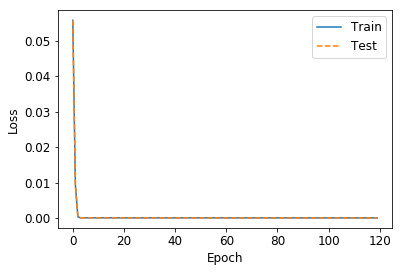

In [51]:
plt.rcParams['font.size'] = 12
plt.plot(hist_train,  label='Train')
plt.plot(hist_test, '--', label='Test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [57]:
def clean_sigal(x, window_size, step=1):
    
    x_normalized = x
    predictions = np.zeros(x_normalized.shape)
    num_present = np.zeros(x_normalized.shape)
    for i in range(0, len(x_normalized) - window_size + 1, step):
        predictions[i: i+window_size] += sess.run(preds, {inp: [x_normalized[i: i+window_size]]})[0]
        num_present[i: i+window_size] += 1
    predictions /= np.clip(num_present, 1e-12, None)
    predictions[i+window_size:] = x_normalized[i+window_size:]
    return predictions

In [69]:
backend.set_learning_phase(0)
mses_noisy, mses_denoised = [], []
for i in range(len(X_test)):
    print("{}'th test point!'".format(i + 1))
    x, y = standardize(X_test[i]), standardize(y_test[i])
    noise = y - x
    mse_noisy = np.mean(noise ** 2)
    mses_noisy.append(mse_noisy)
    x_clean = clean_sigal(x, window_size, step=window_size)
    error = y - x_clean
    mse_denoised = np.mean(error ** 2)
    mses_denoised.append(mse_denoised)
    print(mse_noisy, mse_denoised)

1'th test point!'
6.23417037525e-05 1.32054648589e-05
2'th test point!'
5.17638766646e-05 1.77185674523e-05
3'th test point!'
5.05042761202e-05 1.73812089498e-05
4'th test point!'
4.94769050562e-05 1.74528430744e-05
5'th test point!'
6.84040275549e-05 2.88438133535e-05
6'th test point!'
9.21077361304e-05 1.67179186891e-05
7'th test point!'
4.71305077991e-05 2.3267807633e-05
8'th test point!'
7.91823610034e-05 1.24923487068e-05


In [70]:
print(np.mean(mses_noisy), np.mean(mses_denoised))

6.26139242602e-05 1.83849965897e-05


In [34]:
clean_sigal(X_test[idx], window_size, step=32)[:, channel]

array([  2.92747378,   3.42811823,   6.38388348, ...,  27.59157181,
        27.55619049,  26.80264282])

Text(0.5,1,'Target vs Predicted')

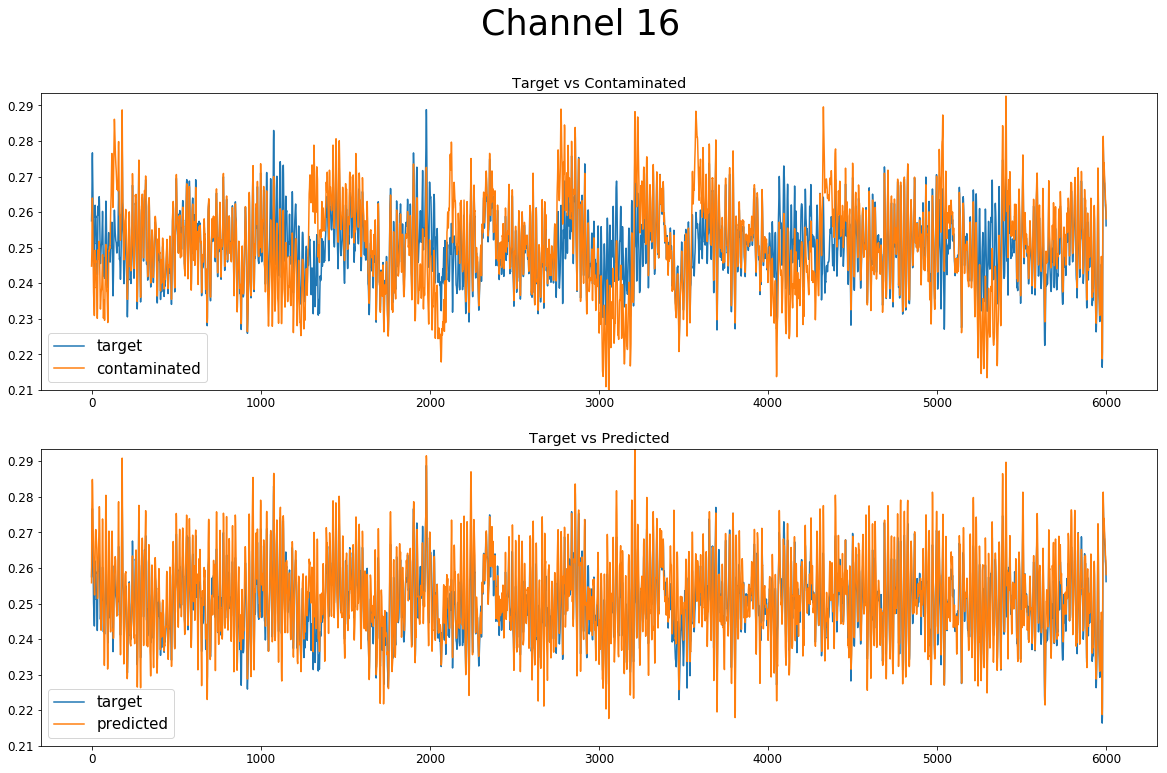

In [153]:
fig = plt.figure(figsize = (20, 12))
idx = np.random.choice(len(X_test))
channel = 16
X_test_patient_channel = standardize(X_test[idx])[:, channel]
y_test_patient_channel = standardize(y_test[idx])[:, channel]
X_test_patient_cleaned_channel = clean_sigal(standardize(X_test[idx]), window_size, step=window_size)[:, channel]
max_value = max(max(X_test_patient_channel.max(), y_test_patient_channel.max()), X_test_patient_cleaned_channel.max())
min_value = min(min(X_test_patient_channel.min(), y_test_patient_channel.min()), X_test_patient_cleaned_channel.min())
noise = y_test_patient_channel - X_test_patient_channel
noise_prime =  y_test_patient_channel - X_test_patient_cleaned_channel
plt.suptitle('Channel {}'.format(channel), fontsize=35)
plt.subplot(2, 1, 1)
plt.plot(y_test_patient_channel, label='target')
plt.plot(X_test_patient_channel, label='contaminated')
plt.ylim([min_value, max_value])
plt.title('Target vs Contaminated')
# plt.plot(noise, label='noise')
plt.legend(fontsize=15)
plt.subplot(2, 1, 2)
plt.plot(y_test_patient_channel, label='target')
plt.plot(X_test_patient_cleaned_channel, label='predicted')
plt.ylim([min_value, max_value])
# plt.plot(noise_prime, label='noise-prime')
plt.title('MSE = {}'.format(np.mean(noise_prime**2)))
plt.legend(fontsize=15)
plt.title('Target vs Predicted')